In [5]:
import datetime
import numpy as np
import backtrader as bt
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Black-Scholes Formula for Call Option Price
def bs_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Black-Scholes Delta
def bs_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Black-Scholes Gamma
def bs_gamma(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

# 
def realized_vol(prices, window=5):
    '''Estimates annualized realized volatility from recent prices
    by computing the standard deviation of log returns over a given window'''
    log_returns = np.log(np.array(prices[1:]) / np.array(prices[:-1]))
    return np.std(log_returns[-window:]) * np.sqrt(252) if len(log_returns) >= window else 0

# Hedge Strategy
class HedgeComparison(bt.Strategy):
    params = dict(
        strike_price=None,
        sigma=0.20,
        r=0.01,
        expiry_days=30,
    )

    def __init__(self):
        self.days = 0
        self.price_hist = []
        self.gamma_theta_pnl_series = []
        self.unhedged_pnl_series = []
        self.option_price_series = []
        self.initial_option_price = None
        self.strike_price = self.p.strike_price
        self.dataclose = self.datas[0].close

    def next(self):
        S = self.data.close[0]
        if self.days == 0 and self.strike_price is None:
            self.strike_price = self.dataclose[0]  # use first day's close
        self.price_hist.append(S)
        T = max((self.p.expiry_days - self.days) / 252, 0)

        # Track option value for unhedged short call
        call_val = bs_call_price(S, self.strike_price, T, self.p.r, self.p.sigma)
        if self.days == 0:
            self.initial_option_price = call_val
        unhedged_pnl = self.initial_option_price - call_val
        self.unhedged_pnl_series.append(unhedged_pnl)

        # Gamma hedged PnL
        if len(self.price_hist) >= 6 and T > 0:
            sigma_r = realized_vol(self.price_hist[-6:])
            gamma = bs_gamma(S, self.strike_price, T, self.p.r, self.p.sigma)
            dt = 1 / 252
            pnl = 0.5 * gamma * S**2 * (sigma_r**2 - self.p.sigma**2) * dt
            self.gamma_theta_pnl_series.append(pnl)
        else:
            self.gamma_theta_pnl_series.append(0)

        self.days += 1

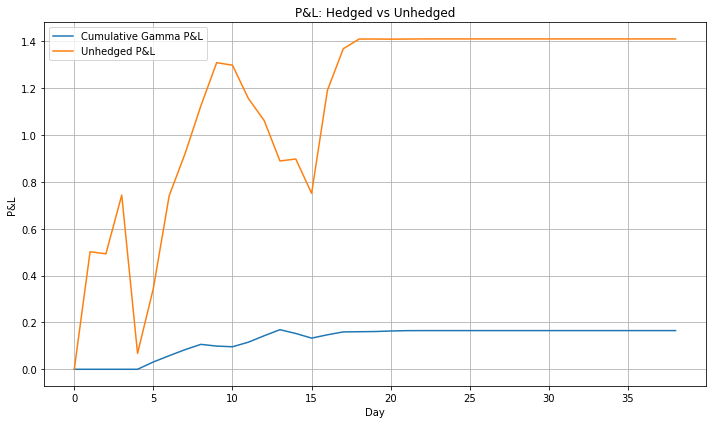

In [11]:
# Code for running backtest and plotting gamma pnl assuming a fixed volatitly (sigma)
if __name__ == '__main__':
    data = bt.feeds.YahooFinanceCSVData(
        dataname='yahoo.csv',
        fromdate=datetime.datetime(2015, 1, 1), # Change timeframe as needed
        todate=datetime.datetime(2015, 2, 28),
        reverse=False)

    cerebro = bt.Cerebro()
    cerebro.addstrategy(HedgeComparison)
    cerebro.adddata(data)
    cerebro.run()

    strat = cerebro.runstrats[0][0]

    # Plot PnL
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(strat.gamma_theta_pnl_series), label='Cumulative Gamma P&L')
    plt.plot(strat.unhedged_pnl_series, label='Unhedged P&L')
    plt.xlabel('Day')
    plt.ylabel('P&L')
    plt.title('P&L: Hedged vs Unhedged')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

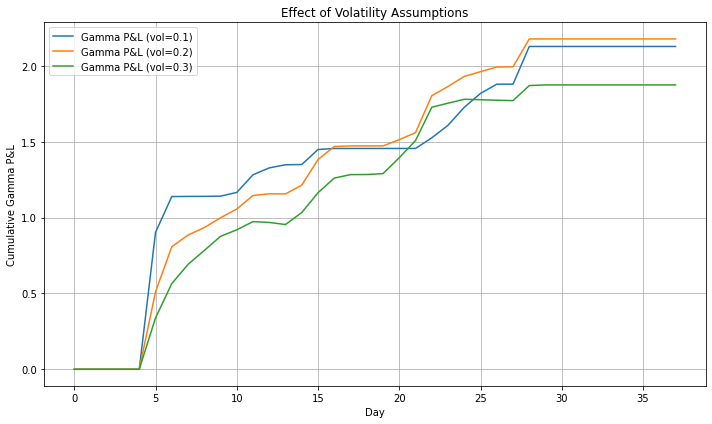

In [14]:
# Code for plotting gamma pnl using differing volatility
sigmas_to_test = [0.1, 0.2, 0.3]
results = {}

for sigma in sigmas_to_test:
    cerebro = bt.Cerebro()
    data = bt.feeds.YahooFinanceCSVData(
        dataname='oracle.csv',
        fromdate=datetime.datetime(2000, 1, 1), # Change timeframe as needed
        todate=datetime.datetime(2000, 2, 28),
        reverse=False)

    cerebro.adddata(data)
    cerebro.addstrategy(HedgeComparison, sigma=sigma)
    strategies = cerebro.run()
    strat = strategies[0]       # Retrieve the strategy instance

    # Store cumulative gamma PnL
    results[sigma] = np.cumsum(strat.gamma_theta_pnl_series)

# Plot Comparison
plt.figure(figsize=(10, 6))
for sigma, pnl in results.items():
    plt.plot(pnl, label=f'Gamma P&L (vol={sigma})')

plt.xlabel("Day")
plt.ylabel("Cumulative Gamma P&L")
plt.title("Effect of Volatility Assumptions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()